# Experiment 04

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

In [1]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler

### Constants and Parameters

In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2020.03.31'
TRAIN_END = '2021.04.05'

#TEST_BEGIN = '2020.06.01'
#TEST_END = '2020.06.15'
#TRAIN_BEGIN = '2019.11.21'
#TRAIN_END = '2020.05.29'
TIMES = 10

### Opening the dataset

In [3]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")

df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [4]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

In [5]:
##df = getPeriod(df, '2020.03.02','2021.04.30', True)
##initialDf = getPeriod(df, '2020.03.02','2021.04.30', True)

In [6]:
initialDf_PETR4 = getPeriod(df, '2019.01.02','2021.06.01', True)
initialDf_VALE3 = getPeriod(df2, '2019.01.02','2021.06.01', True)

In [7]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019.01.02,21.18,22.73,20.93,22.60,20.609175,21.499077,20.380957,21.271656,21.776315,...,19.18,20.37,19.55,20.08,19.41,19.69,20.38,20.39,19.50,19.63
1,2019.01.03,22.51,23.32,22.36,23.16,21.242783,22.106051,21.040638,21.901104,23.157151,...,19.99,20.36,19.34,20.37,19.18,20.37,19.55,20.08,19.41,19.69
2,2019.01.04,23.35,23.43,22.99,23.22,21.945189,22.547367,21.690425,22.340736,24.186721,...,20.74,21.31,20.22,20.65,19.99,20.36,19.34,20.37,19.18,20.37
3,2019.01.07,23.35,24.35,23.20,23.59,22.413459,23.148245,22.193617,22.757157,24.644733,...,20.93,22.60,20.77,21.45,20.74,21.31,20.22,20.65,19.99,20.36
4,2019.01.08,23.86,23.88,23.27,23.45,22.895640,23.392163,22.552411,22.988105,24.953473,...,22.36,23.16,21.18,22.73,20.93,22.60,20.77,21.45,20.74,21.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
595,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
596,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
597,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [8]:
initialDf_VALE3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019.01.02,45.72,46.96,45.52,46.71,45.965361,46.778539,45.580846,46.324671,46.091838,...,45.16,46.11,45.97,46.85,45.91,46.50,46.39,46.78,45.21,45.54
1,2019.01.03,46.44,46.57,44.25,44.80,46.123574,46.709026,45.137231,45.816447,46.532241,...,45.05,45.25,45.81,46.35,45.16,46.11,45.97,46.85,45.91,46.50
2,2019.01.04,45.55,47.95,45.55,47.71,45.932382,47.122684,45.274820,46.447631,46.581616,...,45.94,46.63,45.80,46.07,45.05,45.25,45.81,46.35,45.16,46.11
3,2019.01.07,48.34,49.05,47.28,47.46,46.734922,47.765123,45.943214,46.785088,48.670273,...,45.52,46.71,45.99,46.81,45.94,46.63,45.80,46.07,45.05,45.25
4,2019.01.08,47.72,48.27,47.19,47.91,47.063281,47.933415,46.358809,47.160058,49.216909,...,44.25,44.80,45.72,46.96,45.52,46.71,45.99,46.81,45.94,46.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2021.05.26,106.37,110.32,106.03,110.20,109.166674,111.131617,107.622606,109.807900,113.973861,...,108.50,109.40,111.70,112.10,110.20,111.11,112.10,112.78,109.84,112.25
595,2021.05.27,110.80,112.09,109.77,110.99,109.711116,111.451078,108.338404,110.201933,113.405981,...,107.51,109.78,111.11,111.25,108.50,109.40,111.70,112.10,110.20,111.11
596,2021.05.28,111.11,112.75,109.42,111.59,110.177411,111.884052,108.698936,110.664622,113.405981,...,106.78,107.05,108.00,110.14,107.51,109.78,111.11,111.25,108.50,109.40
597,2021.05.31,112.50,114.89,112.50,114.78,110.951607,112.886035,109.965957,112.036415,114.811204,...,106.03,110.20,110.28,110.89,106.78,107.05,108.00,110.14,107.51,109.78


#### Experimento 04: Utilizando Random Forest

In [9]:
def exp04(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    #print(df)
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train);
    y_pred = rf.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin

def test30timesExp04(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp04(df, stock)
        else: 
            errorMax_petr4, errorMin_petr4 = exp04(df, stock, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25) 
test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')     

PETR4 15 Variables
High: 1.14 +- 0.02 %
Low: 0.63 +- 0.02 %
PETR4 25 Variables
High: 1.17 +- 0.04 %
Low: 0.66 +- 0.01 %
PETR4 33 Variables
High: 1.13 +- 0.04 %
Low: 0.66 +- 0.02 %


VALE3 15 Variables
High: 8.06 +- 0.06 %
Low: 8.75 +- 0.05 %
VALE3 25 Variables
High: 8.09 +- 0.08 %
Low: 8.78 +- 0.07 %
VALE3 33 Variables
High: 8.03 +- 0.05 %
Low: 8.68 +- 0.03 %


In [10]:
df4 = getPeriod(initialDf_PETR4, '2020.03.02','2021.04.30', True)

df_train = getPeriod(df4, '2020.03.02','2021.03.31')
df_test = getPeriod(df4, '2021.04.01','2021.04.30')

x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
y_train = df_train[['high','low']]

x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
y_test = df_test[['high','low']]

rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(x_train, y_train);
y_pred = rf.predict(x_test)

print (mape(y_test['high'],y_pred[:,0]))
print (mape(y_test['low'],y_pred[:,1]))
print (mae(y_test['high'],y_pred[:,0]))
print (mae(y_test['low'],y_pred[:,1]))

(1.1963341010728044, 1.1660900791246553)
(0.8196648669255575, 0.6715461775090307)
(0.28706049999992744, 0.28849986636870034)
(0.1907985000000732, 0.15736205003993478)


Feature: 0, Score: 0.88341
Feature: 1, Score: 0.00176
Feature: 2, Score: 0.00273
Feature: 3, Score: 0.01292
Feature: 4, Score: 0.01413
Feature: 5, Score: 0.00051
Feature: 6, Score: 0.01176
Feature: 7, Score: 0.00057
Feature: 8, Score: 0.00419
Feature: 9, Score: 0.00048
Feature: 10, Score: 0.00268
Feature: 11, Score: 0.00111
Feature: 12, Score: 0.01463
Feature: 13, Score: 0.00384
Feature: 14, Score: 0.00673
Feature: 15, Score: 0.01464
Feature: 16, Score: 0.01854
Feature: 17, Score: 0.00029
Feature: 18, Score: 0.00026
Feature: 19, Score: 0.00125
Feature: 20, Score: 0.00155
Feature: 21, Score: 0.00011
Feature: 22, Score: 0.00013
Feature: 23, Score: 0.00023
Feature: 24, Score: 0.00017
Feature: 25, Score: 0.00014
Feature: 26, Score: 0.00016
Feature: 27, Score: 0.00013
Feature: 28, Score: 0.00019
Feature: 29, Score: 0.00023
Feature: 30, Score: 0.00016
Feature: 31, Score: 0.00019
Feature: 32, Score: 0.00019


<BarContainer object of 33 artists>

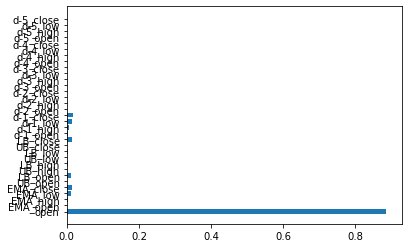

In [11]:
importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

importance

from matplotlib import pyplot as plt
plt.barh(x_train.columns, rf.feature_importances_)

In [12]:
def exp041(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 300)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        print(i)
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')
    
    importance = rf.feature_importances_
    
    featureImp = []
    for feat, importance in zip(x_train.columns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    #fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    #print (fT_df.sort_values('Importance', ascending = False))
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin, y_pred, y_test

a,b,c,d = exp041(initialDf_PETR4, 'PETR4')

e,f,g,h = exp041(initialDf_VALE3, 'VALE3')

1
High: 1.03 +- 0.93 %
Low: 0.67 +- 0.39 %
2
High: 1.15 +- 0.97 %
Low: 0.66 +- 0.45 %
3
High: 1.11 +- 0.92 %
Low: 0.66 +- 0.44 %
4
High: 1.12 +- 1.0 %
Low: 0.65 +- 0.45 %
1
High: 8.05 +- 3.37 %
Low: 8.67 +- 2.98 %
2
High: 8.09 +- 3.37 %
Low: 8.68 +- 2.98 %
3
High: 7.9 +- 3.37 %
Low: 8.58 +- 2.98 %
4
High: 7.87 +- 3.38 %
Low: 8.57 +- 2.99 %


In [13]:
printResult(a, 'High')
printResult(b, 'Low')

High: 1.12 +- 1.0 %
Low: 0.65 +- 0.45 %


In [14]:
d['high_pred'] = c[:,0]
d['low_pred'] = c[:,1]
d['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']
d.to_pickle('../Data/PETR4_Pred.pkl')
d.tail(10)


,high,low,high_pred,low_pred,date
589,26.35,25.80,26.544233,25.747100,2021.05.19
590,26.28,25.72,26.432267,25.706733,2021.05.20
591,26.31,25.94,26.467000,25.697467,2021.05.21
592,26.52,25.99,26.599467,25.804700,2021.05.24
593,26.62,25.78,26.655400,25.911200,2021.05.25
594,26.18,25.65,26.284800,25.570433,2021.05.26
595,26.25,25.77,26.328767,25.614500,2021.05.27
596,27.02,26.15,26.814400,25.954933,2021.05.28
597,27.20,26.78,27.223700,26.573833,2021.05.31
598,27.70,27.01,27.597833,27.120233,2021.06.01


In [15]:
h['high_pred'] = g[:,0]
h['low_pred'] = g[:,1]
h['date'] = getPeriod(initialDf_VALE3, TEST_BEGIN, TEST_END)['date']
h.to_pickle('../Data/VALE3_Pred.pkl')
h.tail(10)

,high,low,high_pred,low_pred,date
589,112.78,109.84,102.36,99.0491,2021.05.19
590,112.10,110.20,102.36,99.0491,2021.05.20
591,111.25,108.50,102.36,99.0491,2021.05.21
592,110.14,107.51,102.36,99.0491,2021.05.24
593,110.89,106.78,102.36,99.0491,2021.05.25
594,110.32,106.03,102.36,99.0491,2021.05.26
595,112.09,109.77,102.36,99.0491,2021.05.27
596,112.75,109.42,102.36,99.0491,2021.05.28
597,114.89,112.50,102.36,99.0491,2021.05.31
598,118.00,113.20,102.36,99.0491,2021.06.01


In [16]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019.01.02,21.18,22.73,20.93,22.60,20.609175,21.499077,20.380957,21.271656,21.776315,...,19.18,20.37,19.55,20.08,19.41,19.69,20.38,20.39,19.50,19.63
1,2019.01.03,22.51,23.32,22.36,23.16,21.242783,22.106051,21.040638,21.901104,23.157151,...,19.99,20.36,19.34,20.37,19.18,20.37,19.55,20.08,19.41,19.69
2,2019.01.04,23.35,23.43,22.99,23.22,21.945189,22.547367,21.690425,22.340736,24.186721,...,20.74,21.31,20.22,20.65,19.99,20.36,19.34,20.37,19.18,20.37
3,2019.01.07,23.35,24.35,23.20,23.59,22.413459,23.148245,22.193617,22.757157,24.644733,...,20.93,22.60,20.77,21.45,20.74,21.31,20.22,20.65,19.99,20.36
4,2019.01.08,23.86,23.88,23.27,23.45,22.895640,23.392163,22.552411,22.988105,24.953473,...,22.36,23.16,21.18,22.73,20.93,22.60,20.77,21.45,20.74,21.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
595,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
596,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
597,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39
